<a href="https://colab.research.google.com/github/rohmadyudiutomo/p300/blob/main/p300_model_by_Deepchem_GNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#DEEPCHEM for preparing p300 activity prediction
must run in GPU

In [ ]:
!pip install --upgrade tensorflow

     |████████████████████████████████| 320.4MB 47kB/s 
  Found existing installation: tensorflow 2.3.0
    Uninstalling tensorflow-2.3.0:
      Successfully uninstalled tensorflow-2.3.0


In [ ]:
# Installing conda
!curl -Lo conda_installer.py https://raw.githubusercontent.com/deepchem/deepchem/master/scripts/colab_install.py
import conda_installer
conda_installer.install()
!/root/miniconda/bin/conda info -e
import numpy as np

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3490  100  3490    0     0  28373      0 --:--:-- --:--:-- --:--:-- 28606


add /root/miniconda/lib/python3.6/site-packages to PYTHONPATH
python version: 3.6.9
fetching installer from https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
done
installing miniconda to /root/miniconda
done
installing rdkit, openmm, pdbfixer
added omnia to channels
added conda-forge to channels
done
conda packages installation finished!


# conda environments:
#
base                  *  /root/miniconda



In [ ]:
# Installing Deepchem
!pip install --pre deepchem
import deepchem
deepchem.__version__

     |████████████████████████████████| 409kB 11.7MB/s 
  Created wheel for deepchem: filename=deepchem-2.4.0rc1.dev20201121094808-cp36-none-any.whl size=516376 sha256=26b68908d7979c9ef5c5e4e0640ce6d9d194a2f9fd1337e397fd9c6bbaeecfbf
  Stored in directory: /root/.cache/pip/wheels/d3/85/9a/a923bd2c2cbc8d2753910b49412e3e442b4c601d16d1208370
Successfully built deepchem


'2.4.0-rc1.dev'

In [ ]:
# Getting the dataset
!wget https://raw.githubusercontent.com/rohmadyudiutomo/p300/main/Cur%20der%20p300%20from%20Yang%20et%20al%20mix%20cur%20dataset.csv
from deepchem.utils.save import load_from_disk
dataset_file= "Cur der p300 from Yang et al mix cur dataset.csv"

# Loading the data from the CSV file
loader = deepchem.data.CSVLoader(tasks=["pIC50"], 
                                 smiles_field="SMILES", 
                                 featurizer=deepchem.feat.ConvMolFeaturizer())
# Featurizing the dataset with ConvMolFeaturizer
dataset = loader.featurize(dataset_file)

--2020-11-21 11:20:06--  https://raw.githubusercontent.com/rohmadyudiutomo/p300/main/Cur%20der%20p300%20from%20Yang%20et%20al%20mix%20cur%20dataset.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13466 (13K) [text/plain]
Saving to: ‘Cur der p300 from Yang et al mix cur dataset.csv’

Cur der p300 from Y 100%[===================>]  13.15K  --.-KB/s    in 0s      

2020-11-21 11:20:06 (96.9 MB/s) - ‘Cur der p300 from Yang et al mix cur dataset.csv’ saved [13466/13466]



smiles_field is deprecated and will be removed in a future version of DeepChem.Use feature_field instead.
/usr/local/lib/python3.6/dist-packages/deepchem/data/data_loader.py:162: FutureWarning: featurize() is deprecated and has been renamed to create_dataset().featurize() will be removed in DeepChem 3.0
  "featurize() will be removed in DeepChem 3.0", FutureWarning)


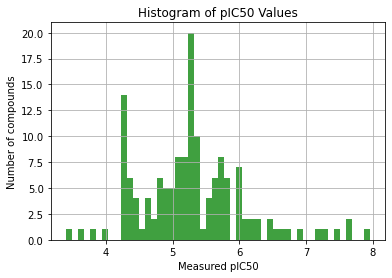

In [ ]:
dataset2 = load_from_disk(dataset_file)
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

pIC50s = np.array(dataset2["pIC50"])
# Remove some dirty data from the dataset
pIC50s = [pIC50 for pIC50 in pIC50s if pIC50 != '']
n, bins, patches = plt.hist(pIC50s, 50, facecolor='green', alpha=0.75)
plt.xlabel('Measured pIC50')
plt.ylabel('Number of compounds')
plt.title(r'Histogram of pIC50 Values')
plt.grid(True)
plt.show()

In [ ]:
# Splitter splits the dataset 
# In this case it's is an equivalent of train_test_split from sklearn
splitter = deepchem.splits.RandomSplitter()
# frac_test is 0.01 because we only use a train and valid as an example
train, valid, _ = splitter.train_valid_test_split(dataset,
                                                  frac_train=0.7,
                                                  frac_valid=0.29,
                                                  frac_test=0.01)

In [ ]:
print(f"Size of the training data: {len(train.ids)}")
print(f"Size of the validation data: {len(valid.ids)}")

Size of the training data: 102
Size of the validation data: 43


In [ ]:
# GraphConvModel is a GNN model based on 
# Duvenaud, David K., et al. "Convolutional networks on graphs for
# learning molecular fingerprints."
import tensorflow as tf
from deepchem.models import GraphConvModel
hp = deepchem.molnet.preset_hyper_parameters
param = hp.hps[ 'graphconvreg' ]
with tf.compat.v1.Session() as sess:
  graph_conv = GraphConvModel(1,
                            batch_size=10,
                            mode="regression",
                            learning_rate = param[ 'learning_rate' ],
                            optimizer_type = 'adam',
                            beta1 = .9, beta2 = .999)
# Defining metric. Closer to 1 is better
metric = deepchem.metrics.Metric(deepchem.metrics.pearson_r2_score)    

In [ ]:
# Fitting the model
graph_conv.fit(train, nb_epoch=1000)

0.03239190816879273

In [ ]:
# Reversing the transformation and getting the metric scores on 2 datasets
train_scores = graph_conv.evaluate(train, [metric])
valid_scores = graph_conv.evaluate(valid, [metric])
print(f"Train Scores: {train_scores}")
print(f"Validation Scores: {valid_scores}")

Train Scores: {'pearson_r2_score': 0.9519594205357743}
Validation Scores: {'pearson_r2_score': 0.3282611855356514}


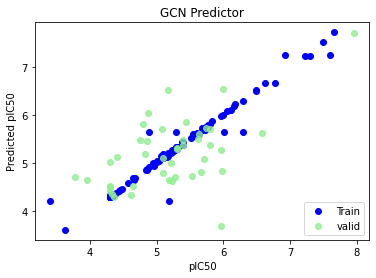

In [ ]:
pred_train = graph_conv.predict( train )
pred_valid = graph_conv.predict( valid )
 
y_train = np.array( train.y, dtype = np.float32 )
y_valid = np.array( valid.y, dtype = np.float32 )
pred_train = np.array( pred_train, dtype=np.float32 )
pred_valid = np.array( pred_valid, dtype=np.float32)
  
import matplotlib.pyplot as plt
 
plt.figure()
plt.scatter( y_train, pred_train, label = 'Train', c = 'blue' )
plt.title( 'GCN Predictor' )
plt.xlabel( 'pIC50' )
plt.ylabel( 'Predicted pIC50' )
plt.scatter( y_valid, pred_valid, c = 'lightgreen', label = 'valid', alpha=0.8)
plt.legend( loc = 4 )
plt.show()

In [ ]:
smiles = ['O=C(CC(/C=C/C1=CC=C(O)C(O)=C1)=O)/C=C/C2=CC(OC)=C(O)C=C2','O=C(CC(/C=C/C1=CC=C(O)C(O)=C1)=O)/C=C/C2=CC(OC(O)=O)=C(O)C=C2','O=C(CC(/C=C/C1=CC=C(O)C(O)=C1)=O)/C=C/C2=CC(Br)=C(O)C=C2','O=C(CC(/C=C/C1=CC=C(O)C(OC)=C1)=O)/C=C/C2=CC(OC(O)=O)=C(O)C=C2','O=C(CC(/C=C/C1=CC=C(O)C(OC)=C1)=O)/C=C/C2=CC(Br)=C(O)C=C2','O=C(CC(/C=C/C1=CC=C(O)C(Br)=C1)=O)/C=C/C2=CC(OC(O)=O)=C(O)C=C2','O=C(/C(CCC/1)=C/C2=CC(OC)=C(O)C=C2)C1=C\C3=CC=C(O)C(O)=C3','O=C(/C(CCC/1)=C/C2=CC(OC(O)=O)=C(O)C=C2)C1=C\C3=CC=C(O)C(O)=C3','O=C(/C(CCC/1)=C/C2=CC(Br)=C(O)C=C2)C1=C\C3=CC=C(O)C(O)=C3','O=C(/C(CCC/1)=C/C2=CC(OC(O)=O)=C(O)C=C2)C1=C\C3=CC=C(O)C(OC)=C3','O=C(/C(CCC/1)=C/C2=CC(Br)=C(O)C=C2)C1=C\C3=CC=C(O)C(OC)=C3','O=C(/C(CCC/1)=C/C2=CC(OC(O)=O)=C(O)C=C2)C1=C\C3=CC=C(O)C(Br)=C3','O=C(CC(/C=C/C1=CC=C(O)C(OC)=C1)=O)/C=C/C2=CC(OC)=C(O)C=C2','O=C1/C(CCC/C1=C\C2=CC=C(C(Br)=C2)O)=C/C3=CC(Br)=C(C=C3)O']

In [ ]:
from rdkit import Chem
mols = [Chem.MolFromSmiles(s) for s in smiles]
featurizer = deepchem.feat.ConvMolFeaturizer()
x = featurizer.featurize(mols)

predicted_pIC50 = graph_conv.predict_on_batch(x)
predicted_pIC50

array([[4.277486 ],
       [4.952159 ],
       [4.5828233],
       [5.0007176],
       [4.8953032],
       [5.1947427],
       [4.075317 ],
       [4.6395907],
       [4.869366 ],
       [4.9363875],
       [5.335767 ],
       [5.3548574],
       [4.6508403],
       [5.295529 ]], dtype=float32)